In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import final_project_functions as fun
import time
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd

In [3]:
players = pd.read_csv("Data/players.csv")
players['height'] = players.height.apply(lambda cell: fun.fix_height(cell))

In [191]:
import pickle

In [192]:
games = pd.read_csv("Data/games.csv")
players = pd.read_csv("Data/players.csv")
plays = pd.read_csv("Data/plays.csv")
weeks = pd.read_csv("Data/week1.csv")
weeks['week'] = 1

for i in range(2, 18):
    week_temp = pd.read_csv("Data/week{}.csv".format(i))
    week_temp['week'] = i
    weeks = pd.merge(weeks, week_temp, how='outer')
    print(i)

OFFENSE = ['QB', 'RB', 'WR', 'TE', 'FB']

# Necessary to clean height data
players['height'] = players.height.apply(lambda cell: fun.fix_height(cell))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


- Measuring which players are the most effective at intercepting and sacking throughout the nfl, along with looking at stats such as the number of penalties and passes completed while they were on the field or against them to measure if they were responsible for the play

In [193]:
#weeks.to_pickle("all_weeks") 

In [318]:
#pd.read_pickle("all_weeks")

week_columns =['pass_forward', 'pass_arrived',
       'pass_outcome_caught',  'pass_outcome_incomplete',
       'tackle', 'play_action',
       'qb_sack', 'fumble', 'fumble_offense_recovered',
       'pass_tipped', 'pass_outcome_interception', 'qb_strip_sack',
       'touchdown',
       'fumble_defense_recovered', 'pass_outcome_touchdown',
        'penalty_flag', 'penalty_accepted']

In [195]:
players_extra = pd.read_csv("Data/playerInformation/players.csv")
combine = pd.read_csv("Data/playerInformation/combine.csv")
combine_extra = pd.read_csv("Data/playerInformation/combine_data_since_2000_PROCESSED_2018-04-26.csv")

In [319]:
fp = "Data/playerinformation/cb_2018_us_state_500k.shp"
map_df = gpd.read_file(fp)
map_df.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."


In [431]:
def fixDate(day):
    if day.count("-") >1:
        return int(day[:4])
    elif day.count("/") >1:
        return int(day[-4:])
    else:
        print(day)

In [432]:
players['birthYear'] = players['birthDate'].apply(lambda day: fixDate(day))
players['nflId'] = players.nflId.astype(str)

In [433]:
df_all_players = pd.merge(players, players_extra, on='nflId')#, how='outer', indicator=True)
all_players_cols = ['nflId', 'height', 'weight_x','combineId', 'birthDate', 'collegeName', 'position_x',
       'displayName', 'birthYear', 'playerId', 'nameFirst', 'nameLast', 'collegeId', 'college',
       'heightInches', 'dob', 'ageAtDraft',
       'homeCity', 'homeState', 'homeCountry', 'highSchool', 'hsCity',
       'hsState', 'hsCountry']
df_all_players = df_all_players.drop_duplicates()
df_all_players[all_players_cols].head(3)

,nflId,height,weight_x,combineId,birthDate,collegeName,position_x,displayName,birthYear,playerId,...,heightInches,dob,ageAtDraft,homeCity,homeState,homeCountry,highSchool,hsCity,hsState,hsCountry
0,2539334,72,190,18228.0,1990-09-10,Washington,CB,Desmond Trufant,1990,20130022,...,72.0,1990-09-10,22.638356,Tacoma,WA,USA,Woodrow Wilson HS,Tacoma,WA,USA
1,2539653,70,186,17976.0,1988-11-01,Southeastern Louisiana,CB,Robert Alford,1988,20130060,...,70.0,1988-11-01,24.495890,Hammond,LA,USA,Hammond HS,NaN,LA,USA
2,2543850,69,186,18270.0,1991-12-18,Purdue,SS,Ricardo Allen,1991,20140147,...,69.0,1991-12-18,22.402740,Daytona Beach,FL,USA,Mainland HS,Daytona Beach,FL,USA


In [434]:
combine_cols_add = ['combineYear', 'combinePosition',
       'combineHeight', 'combineWeight', 'combineHand','nflId',
       'combineArm', 'combine40yd', 'combineVert',
       'combineBench', 'combineShuttle', 'combineBroad', 'combine3cone',
       'combine60ydShuttle', 'combineWonderlic']
combine_new = combine[combine_cols_add]

In [435]:
df_comb = pd.merge(combine_new, df_all_players, on='nflId', how='outer', indicator=True)
df_full = df_comb[df_comb._merge == 'both']
df_missing = df_comb[df_comb._merge == 'right_only']
df_comb = df_comb[df_comb._merge != 'left_only']
df_a = df_full.copy()

In [436]:
switch = {'Forty':'combine40yd', 'BenchReps':'combineBench', 'BroadJump':'combineBroad','Cone':'combine3cone', 'Shuttle':'combineShuttle','Year':'combineYear'}
extra_cols = ['Player']+ list(switch.keys()) # + ['Round', 'Pick']
df_missing = df_missing.loc[:, df_missing.columns != "_merge"]
df_added = df_missing.copy()
df_added = df_added[df_added.columns[~df_added.columns.isin(list(switch.values()))]]

df_extra = pd.merge(combine_extra[extra_cols], df_added, left_on='Player', right_on='displayName')
df_extra = df_extra.rename(columns =switch)

df_extra = df_extra.loc[:, df_extra.columns!="Player"]
df_extra['combineId'] = 1 # removes from undrafted list players

df_temp = pd.merge(df_extra['displayName'], df_missing, on='displayName', how="outer", indicator = True)
df_remain = df_temp[df_temp._merge == 'right_only'].loc[:, df_temp.columns != '_merge']


In [437]:
df_fixed = pd.concat([df_full, df_extra, df_remain])
df_fixed = df_fixed.loc[:, df_fixed.columns != '_merge']
print(df_fixed.shape) # same size as original players dataframe
df_fixed.head(2)

(1304, 42)


,combineYear,combinePosition,combineHeight,combineWeight,combineHand,nflId,combineArm,combine40yd,combineVert,combineBench,...,dob,ageAtDraft,playerProfileUrl,homeCity,homeState,homeCountry,highSchool,hsCity,hsState,hsCountry
4370,2000.0,QB,76.4,211.0,NaN,2504211,NaN,5.30,24.5,NaN,...,1977-08-03,22.715068,http://www.nfl.com/player/TomBrady/2504211/pro...,San Mateo,CA,USA,Serra HS,San Mateo,CA,USA
4641,2001.0,QB,72.3,213.0,NaN,2504775,NaN,4.85,32.0,NaN,...,1979-01-15,22.279452,http://www.nfl.com/player/DrewBrees/2504775/pr...,Austin,TX,USA,Westlake HS,Austin,TX,USA


In [438]:
comb_columns = [
       'combineYear', 'combinePosition', 'combineHeight', 'combineWeight',
       'combineHand', 'nflId', 'combineArm', 'combine40yd', 'combineVert',
       'combineBench', 'combineShuttle', 'combineBroad', 'combine3cone',
       'combine60ydShuttle', 'combineWonderlic', 'height', 'weight_x',
       'birthDate', 'collegeName', 'position_x', 'displayName', 'birthYear',
       'playerId', 'collegeId', 'combineId', 'heightInches', 'dob',
       'ageAtDraft', 'homeCity', 'homeState','homeCountry', 'highSchool',
        'hsCity', 'hsState', 'hsCountry'
]
df_comb = df_fixed[comb_columns]
df_comb = df_comb.rename(columns={"weight_x":"weight", 'position_x':'position'})
df_comb.columns

Index(['combineYear', 'combinePosition', 'combineHeight', 'combineWeight',
       'combineHand', 'nflId', 'combineArm', 'combine40yd', 'combineVert',
       'combineBench', 'combineShuttle', 'combineBroad', 'combine3cone',
       'combine60ydShuttle', 'combineWonderlic', 'height', 'weight',
       'birthDate', 'collegeName', 'position', 'displayName', 'birthYear',
       'playerId', 'collegeId', 'combineId', 'heightInches', 'dob',
       'ageAtDraft', 'homeCity', 'homeState', 'homeCountry', 'highSchool',
       'hsCity', 'hsState', 'hsCountry'],
      dtype='object')

In [332]:
# columns_int = ['nflId', 'displayName', 'event', 'gameId','playId','team', 
#               'homeTeamAbbr','visitorTeamAbbr', 'position', 'frameId','quarter', 'week']

## Finding Players who Intercepted the Ball during the 17 weeks

In [439]:
db_only = ["DB", "CB", "SS", "FS", "S"]

In [448]:
def shorten(name):
    """
    Shortens full name to use to compare and group
    """
    first_last = name.split(" ")
    short = first_last[0][0] + "."
    short+="".join(first_last[1:])
    return short

def clean_description(row, keyword):
    """
    Parses out just the name based on keyword
    """
    start = row.index(keyword) + len(keyword)
    word = row[start:]
    word = word[:word.index(" ")]
    return word

def get_team(row):
    """
    Gets what team the player players on 
    """
    poss = getattr(row, 'possessionTeam')
    home = getattr(row, "homeTeamAbbr")
    away = getattr(row, "visitorTeamAbbr")
    # print(row)
    return away if poss==home else home

In [449]:
def organize_by(keyword,event_word, plays, games, week, players):
    """
    Gets only players related to the chose keyword
    """

    if keyword==None:
        df_plays = plays[['playDescription','possessionTeam','quarter', 'gameId','playId']]
    else:
        plays = plays[plays.passResult == "IN"] # ! Getting only passes ruled interceptions
        df_plays = plays[plays.playDescription.str.contains(keyword)][['playDescription','possessionTeam','quarter', 'gameId','playId']]

    
    df_merge_games = pd.merge(df_plays, games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr','week']], how='inner', on='gameId')


    df_merge_week = pd.merge(df_merge_games, week[['gameId', 'playId','nflId', 'displayName', 'event', 'x','y', 'frameId', 'week', 'position']], on=['gameId', 'playId', 'week'])
    # getting only defensive players
    df_defense = df_merge_week[~df_merge_week.position.isin(OFFENSE)]
    # only look at frames with interception
    df_defense = df_defense[df_defense.event == event_word]

    df_defense['shorten_name'] = df_defense.displayName.apply(lambda row: shorten(row))


    if keyword:
        df_defense['playDescription'] = df_defense['playDescription'].apply(lambda row: clean_description(row, keyword))

    df_defense['team'] = df_defense[['possessionTeam', 'homeTeamAbbr', 'visitorTeamAbbr']].apply(lambda row: get_team(row), axis=1)
    
    if keyword == None:
        return df_defense
    else:
        return df_defense[df_defense.playDescription == df_defense.shorten_name]

In [446]:
df_int = organize_by("INTERCEPTED by ", 'pass_outcome_interception',plays, games, weeks, players)
# df_int = df_int[columns_int]
df_int['type'] = 'interception'
df_int['nflId'] = df_int.nflId.astype(int)
df_int = df_int[df_int.position.isin(db_only)]
print(df_int.shape)


(317, 18)
6.861001014709473


In [350]:
df_int.head(2)

,playDescription,possessionTeam,quarter,gameId,playId,homeTeamAbbr,visitorTeamAbbr,week,nflId,displayName,event,x,y,frameId,position,shorten_name,team,type
767,R.Douglas,ATL,4,2018090600,3392,PHI,ATL,1,2558168,Rasul Douglas,pass_outcome_interception,14.01,0.55,55,CB,R.Douglas,PHI,interception
3235,D.Ward,PIT,1,2018090901,704,CLE,PIT,1,2560916,Denzel Ward,pass_outcome_interception,96.88,9.97,60,CB,D.Ward,CLE,interception


## Finding Defensive Backs who deflected a pass during the 17 weeks

In [452]:
def get_defender(row):
    descript = getattr(row, "playDescription")
    name = getattr(row, "shorten_name")

    words = descript[descript.index('incomplete'):]
    output = []
    if "(" in words:
        words = words[words.index("(")+1:words.index(")")]

    if ',' in words:
        words= words.split(', ')
    else:
        words = [words]

    if name in words:
        return True
    else:
        return np.nan
    
def defense_on_throw(keyword,event_word, plays, games, week, players):
    """
    Looking for who pass is incomplete to. Then looking for the closest defender to the offensive player and in comparison to the ball.
    """
    # gets all confirmed incomplete passes
    plays = plays[plays.passResult == "I"]
    if keyword==None:
        df_plays = plays[['playDescription','possessionTeam', 'quarter', 'gameId','playId']]
    else:
        df_plays = plays[plays.playDescription.str.contains(keyword)][['playDescription','possessionTeam', 'gameId','playId']]
    
    df_merge_games = pd.merge(df_plays, games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr','week']], how='inner', on='gameId')

    df_merge_week = pd.merge(df_merge_games, week[['gameId', 'playId','nflId', 'displayName', 'event', 'x','y', 'frameId', 'week', 'position']], on=['gameId', 'playId', 'week'])
    df_defense = df_merge_week[~df_merge_week.position.isin(['QB'])]
    df_defense = df_defense[df_defense.event == event_word]
    df_defense['team'] = df_defense[['possessionTeam', 'homeTeamAbbr', 'visitorTeamAbbr']].apply(lambda row: get_team(row), axis=1)

    df_defense['shorten_name'] = df_defense.displayName.apply(lambda row: shorten(row))
    df_defense['defenders'] = df_defense[['playDescription', 'shorten_name']].apply(lambda row: get_defender(row), axis=1)

    return df_defense.dropna()


In [453]:
df_deflections = defense_on_throw(None, 'pass_outcome_incomplete',plays, games, weeks, players)
# df_deflections = df_deflections[columns_int]
df_deflections['type'] = 'deflection'
df_deflections['nflId'] = df_deflections.nflId.astype(int)
df_deflections = df_deflections[df_deflections.position.isin(db_only)]
df_deflections.shape

(1149, 19)

In [454]:
df_deflections.head(2)

,playDescription,possessionTeam,quarter,gameId,playId,homeTeamAbbr,visitorTeamAbbr,week,nflId,displayName,event,x,y,frameId,position,team,shorten_name,defenders,type
665,(13:10) M.Ryan pass incomplete short right to ...,ATL,1,2018090600,146,PHI,ATL,1,2555383,Jalen Mills,pass_outcome_incomplete,46.98,38.04,48,CB,PHI,J.Mills,True,deflection
2573,(9:24) (Shotgun) N.Foles pass incomplete short...,PHI,1,2018090600,344,PHI,ATL,1,2543850,Ricardo Allen,pass_outcome_incomplete,22.79,45.92,44,SS,ATL,R.Allen,True,deflection


In [343]:
fun.coverage_stats(plays, 'typeDropback', 'personnelD', 'playResult')

,typeDropback,personnelD,playResult_avg
12,SCRAMBLE,"3 DL, 4 LB, 4 DB",-1.652174
47,UNKNOWN,"4 DL, 2 LB, 5 DB",0.961538
27,SCRAMBLE_ROLLOUT_RIGHT,"3 DL, 4 LB, 4 DB",3.516667
17,SCRAMBLE_ROLLOUT_LEFT,"3 DL, 2 LB, 6 DB",4.428571
31,TRADITIONAL,"0 DL, 4 LB, 7 DB",4.500000
5,DESIGNED_ROLLOUT_RIGHT,"3 DL, 4 LB, 4 DB",4.948718
0,DESIGNED_ROLLOUT_LEFT,"2 DL, 4 LB, 5 DB",5.333333


In [344]:
fun.coverage_stats(plays, 'personnelO', 'personnelD', 'epa').head()

,personnelO,personnelD,epa_avg
6,"1 RB, 1 TE, 3 WR","0 DL, 4 LB, 7 DB",-1.017292
0,"0 RB, 1 TE, 4 WR","3 DL, 3 LB, 5 DB",-0.196070
3,"1 RB, 0 TE, 4 WR","3 DL, 3 LB, 5 DB",-0.170619
26,"1 RB, 2 TE, 2 WR","4 DL, 1 LB, 6 DB",-0.107119
43,"2 RB, 2 TE, 1 WR","3 DL, 4 LB, 4 DB",-0.094778


### Next step is seeing if we can find patterns with these players for interceptions and deflecting

In [353]:
df_all = pd.merge(df_deflections, df_int, how='outer')

In [354]:
df_all.position.unique()

array(['CB', 'SS', 'FS', 'DB', 'S'], dtype=object)

In [308]:
# # db -> defensive-back includes corner backs and safety's
# df_deflection_db = df_deflections[df_deflections.position.isin(db_only)]
# df_int_db = df_int[df_int.position.isin(db_only)]
# df_all_db = pd.merge(df_deflection_db, df_int_db, how='outer')

In [355]:
df_us = map_df.copy()

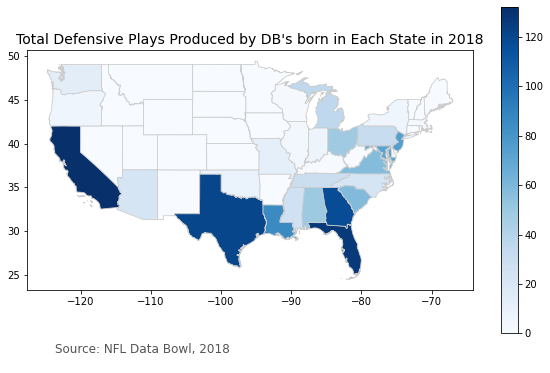

In [367]:
#'homeCity', 'homeState', 'homeCountry', 'highSchool','hsCity', 'hsState', 'hsCountry'
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
df_comb.nflId = df_comb.nflId.astype(int)
fun.plot_map('hsState', df_all,df_comb, df_us, "Total Defensive Plays Produced by DB's born in Each State in 2018", 14)

In [375]:
# def_x

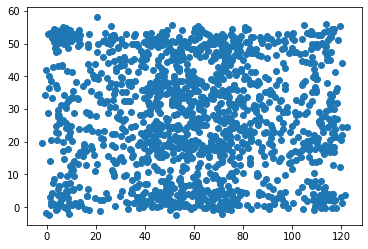

In [382]:
# Interception Location 
def_x = df_all.x.tolist()
def_y = df_all.y.tolist()
plt.scatter(def_x, def_y)

In [425]:
q = dict(df_int.quarter.value_counts())
d = dict(df_deflections.quarter.value_counts())
d = {k:v for k,v in d.items() if k!=5}
q = {k:q[k] for k in sorted(list(q.keys()))}
d = {k:d[k] for k in sorted(list(d.keys()))}

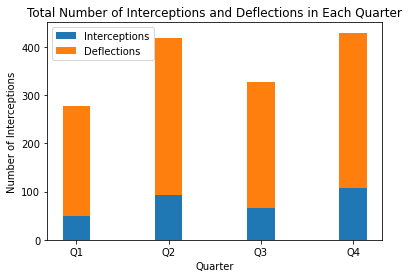

In [430]:
width=0.3
plt.bar(list(q.keys()), list(q.values()), width)
# plt.bar([i+width for i in list(d.keys())], list(d.values()), width, bottom=[q[i] for i in d.keys()])
plt.bar(list(d.keys()), list(d.values()), width, bottom=[q[i] for i in d.keys()])

# plt.xticks([i + width / 2 for i in list(d.keys())], ('Q1', 'Q2', 'Q3', 'Q4'))
plt.xticks([i for i in list(d.keys())], ('Q1', 'Q2', 'Q3', 'Q4'))

plt.xlabel('Quarter')
plt.ylabel('Number of Interceptions')
plt.title('Total Number of Interceptions and Deflections in Each Quarter')
plt.legend(loc='best', labels=('Interceptions', 'Deflections'))
plt.show()

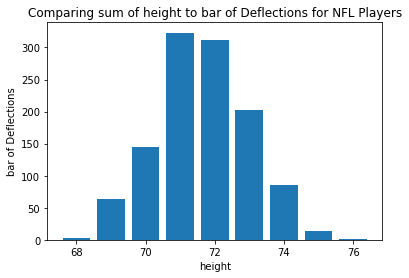

In [369]:
col_val='height'

data, column, df, ylabel,plot, agg = df_deflections, col_val, df_comb, 'Deflections', 'bar', 'sum'
x_vals, y_vals = fun.get_agg(data, column, df)
plt.bar(x_vals, y_vals)
plt.xlabel(column)
y_final_label = "{} of {}".format(plot,ylabel)
plt.ylabel(y_final_label)
plt.title("Comparing {} of {} to {} for NFL Players".format(agg,column, y_final_label))


plt.show()

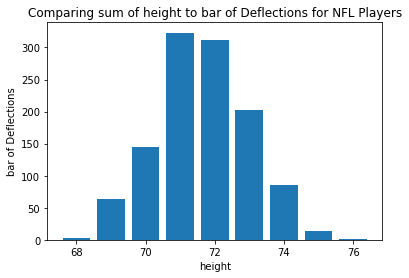

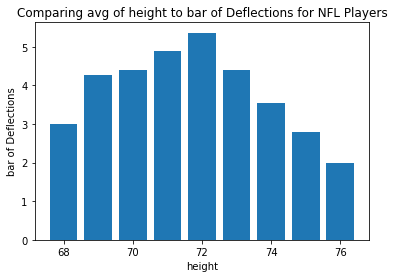

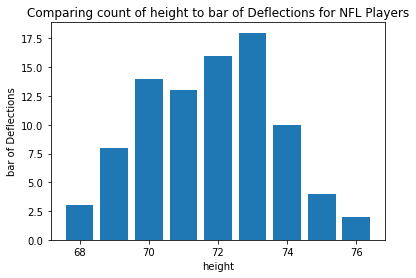

In [298]:
col_val = 'height'
df_db = df_deflections[df_deflections.position.isin(['CB', 'SS', 'FS', 'S', 'DB'])]
fun.plot_points(df_db, col_val, df_comb, 'Deflections', 'bar', 'sum')
fun.plot_points(df_db, col_val, df_comb, "Deflections", 'bar', 'avg')
fun.plot_points(df_db, col_val, df_comb, "Deflections", 'bar', 'count')


In [305]:
df_comb[df_comb.nflId.astype(str).isin(df_db.nflId.tolist())][['combinePosition', 'combine40yd', 'displayName']]

,combinePosition,combine40yd,displayName


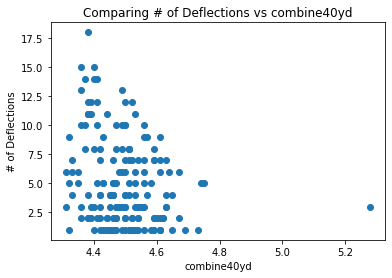

In [299]:
x_column = 'combine40yd'

x_vals, y_vals = fun.get_xy(df_db, x_column, df_comb)
plt.scatter(x_vals, y_vals)
plt.ylabel("# of Deflections")
plt.xlabel(x_column)
plt.title("Comparing # of Deflections vs {}".format(x_column))
plt.show()

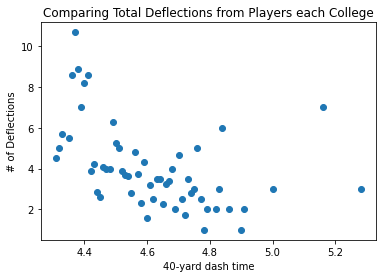

In [227]:

values = fun.get_agg(df_deflections, 'combine40yd', df_comb, avg=True)
x_vals, y_vals = [], []
for i in values:
    x_vals.append(i[0])
    y_vals.append(i[1])

plt.scatter(x_vals, y_vals)
plt.xlabel("40-yard dash time")
plt.ylabel("# of Deflections")
plt.title("Comparing Total Deflections from Players each College")

plt.show()

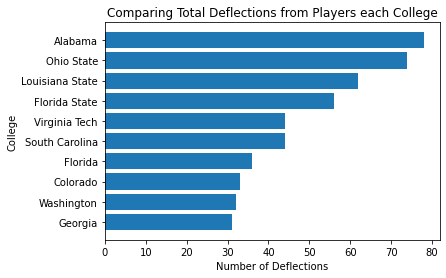

In [228]:
values = fun.get_agg(df_deflections, 'collegeName', df_comb, False)
x_vals, y_vals = [], []
for i in values[-10:]:
    x_vals.append(i[0])
    y_vals.append(i[1])

plt.barh(x_vals, y_vals)
plt.xlabel("Number of Deflections")
plt.ylabel("College")
plt.title("Comparing Total Deflections from Players each College")
plt.show()

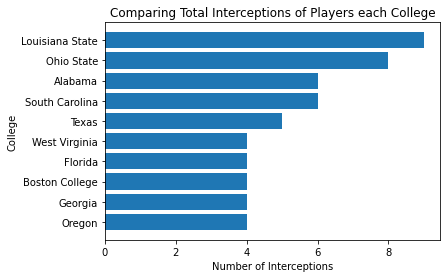

In [831]:
values = fun.get_agg(df_int, 'collegeName', df_comb, avg=False)
x_vals, y_vals = [], []
for i in values[-10:]:
    x_vals.append(i[0])
    y_vals.append(i[1])

plt.barh(x_vals, y_vals)
plt.xlabel("Number of Interceptions")
plt.ylabel("College")
plt.title("Comparing Total Interceptions of Players each College")
plt.show()

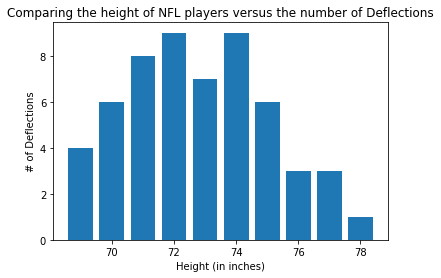

In [832]:
x_vals, y_vals = fun.get_xy(df_deflections, 'height', df_comb)
plt.bar(x_vals, y_vals)
plt.ylabel("# of Deflections")
plt.xlabel("Height (in inches)")
plt.title("Comparing the height of NFL players versus the number of Deflections")
plt.show()

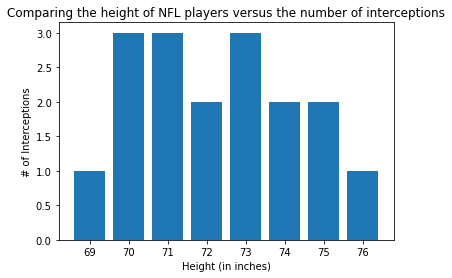

In [833]:
x_vals, y_vals = fun.get_xy(df_int, 'height', df_comb)
plt.bar(x_vals, y_vals)
plt.ylabel("# of Interceptions")
plt.xlabel("Height (in inches)")
plt.title("Comparing the height of NFL players versus the number of interceptions")
plt.show()

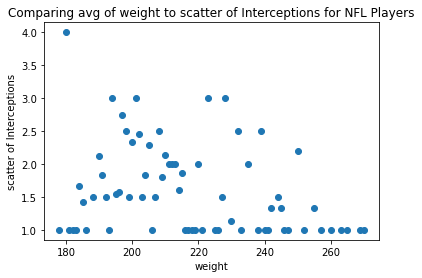

In [229]:
fun.plot_points(df_int, 'weight', df_comb, ylabel='Interceptions', plot='scatter',agg='avg')

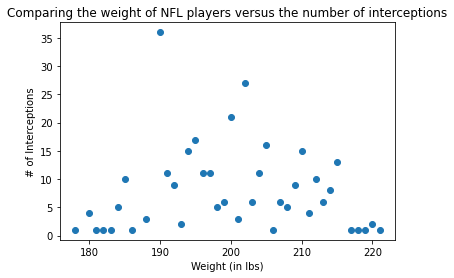

In [368]:
x_vals, y_vals = fun.get_agg(df_int, 'weight', df_comb)
plt.scatter(x_vals, y_vals)
plt.ylabel("# of Interceptions")
plt.xlabel("Weight (in lbs)")
plt.title("Comparing the weight of NFL players versus the number of interceptions")
plt.show()

# Below is practice from previous

------

In [51]:
checking = players[players.position.isin(["QB", "RB", "WR", "TE"])][['position', 'displayName']]

In [305]:
keyword = "INTERCEPTED"
df_int = plays[plays.playDescription.str.contains(keyword)][['playDescription','possessionTeam', 'gameId']]
df_merge = pd.merge(df_int, games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']], how='inner', on='gameId')

In [224]:
keyword

'INTERCEPTED'

In [306]:
df_plays = plays[plays.playDescription.str.contains(keyword)][['playDescription','possessionTeam', 'gameId','playId']]

In [307]:
df_merge_games = pd.merge(df_plays, games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr','week']], how='inner', on='gameId')

In [308]:
week1['week'] = 1
# week1 = week1.drop(columns=['week1'])

In [309]:
df_merge_week = pd.merge(df_merge_games, week1[['gameId', 'playId','nflId', 'displayName', 'event', 'x','y', 'frameId', 'week', 'position']], on=['gameId', 'playId', 'week'])

In [310]:
df_defense = df_merge_week[~df_merge_week.position.isin(OFFENSE)]

In [311]:
df_defense = df_defense[df_defense.event == 'pass_outcome_interception']

In [254]:
def clean_description(row, keyword):
#     print(keyword, row)
    start = row.index(keyword) + len(keyword)
    word = row[start:]
#     print(word)
    word = word[:word.index(" ")]
    
    return word
    
    
    
    

    

In [312]:
df_defense.loc[:,'playDescription'] = df_defense['playDescription'].apply(lambda row: clean_description(row, 'INTERCEPTED by '))

In [313]:
def shorten(name):
    first_last = name.split(" ")
    short = first_last[0][0] + "."
    short+="".join(first_last[1:])
    return short

In [276]:
# shorten("Jacob Michal-Rick")

In [315]:
df_defense.loc[:, 'shorten_name'] = df_defense.displayName.apply(lambda row: shorten(row))

In [321]:
df_defense[df_defense.playDescription == df_defense.shorten_name].shape

(30, 15)

In [123]:
# df_merge_week[(df_merge_week.gameId == 2018090600)]

In [58]:
dname = {k:v for k, v in sorted(dict(Counter(checking)).items(), key=lambda pair:pair[1], reverse=True)}

In [59]:
dname

{'position': 1, 'displayName': 1}

In [113]:
# sorted(dict(Counter(names)).items(), key=lambda pair: pair[1], reverse=True)

In [114]:
# names

In [64]:
# te = inte[inte.frameId == 55][['x', 'y', 'nflId', 'displayName']]
# te

In [51]:
football = te[te.displayName == "Football"][['x', 'y']]
football_x = football.x.values[0]
football_y = football.y.values[0]

In [52]:
football = te[te.displayName == "Football"][['x', 'y']]
football_x = football.x.values[0]
football_y = football.y.values[0]
loc = [te.x.values, te.y.values, te.nflId.values]
def distance(x1, y1, x2, y2):
    return math.sqrt((y1 - y1)**2  + (x1-x2)**2)
dist = [(distance(football_x, football_y, x, y), nfl) for x, y, nfl in zip(loc[0], loc[1], loc[2]) if not np.isnan(nfl)]

In [53]:
loc = [te.x.values, te.y.values, te.nflId.values]

In [54]:
import math

In [55]:
dist = [(distance(football_x, football_y, x, y), nfl) for x, y, nfl in zip(loc[0], loc[1], loc[2]) if not np.isnan(nfl)]

In [56]:
np.isnan()

ValueError: invalid number of arguments

In [57]:
dist

[(21.4, 310.0),
 (16.17, 79848.0),
 (2.9300000000000015, 2495454.0),
 (5.790000000000001, 2495613.0),
 (7.0600000000000005, 2533040.0),
 (19.559999999999995, 2534832.0),
 (20.939999999999998, 2543583.0),
 (18.71, 2552315.0),
 (6.380000000000001, 2555383.0),
 (6.9, 2555415.0),
 (5.4, 2557958.0),
 (0.120000000000001, 2558168.0),
 (5.040000000000001, 2560854.0)]

In [58]:
players[players.nflId == min(dist, key = lambda pair: pair[0])[1]]

,nflId,height,weight,birthDate,collegeName,position,displayName
44,2558168,74,209,1995-08-29,West Virginia,CB,Rasul Douglas


In [ ]:


for row in te.itertuples():
#     print(row)
    x = getattr(row, 'x')
    y = getattr(row, 'y')
    
    nflId = getattr(row, "nflId")
    
    
    
    

In [49]:
te = inte[inte.frameId == 55][['x', 'y', 'nflId', 'displayName']]
te

,x,y,nflId,displayName
56442,35.53,26.76,310.0,Matt Ryan
56443,30.30,30.04,79848.0,Malcolm Jenkins
56444,11.20,1.48,2495454.0,Julio Jones
56445,19.92,23.90,2495613.0,Corey Graham
56446,21.19,28.26,2533040.0,Mohamed Sanu
56447,33.69,32.01,2534832.0,Rodney McLeod
56448,35.07,30.84,2543583.0,Devonta Freeman
56449,32.84,30.56,2552315.0,Jordan Hicks
56450,7.75,43.95,2555383.0,Jalen Mills
56451,7.23,46.56,2555415.0,Austin Hooper


In [ ]:
# def throw_stats(plays):
stats = {}
test = plays[['possessionTeam', 'passResult', 'offensePlayResult']]
#     test.head()
passing = test[['possessionTeam', 'offensePlayResult']].groupby(by='possessionTeam', as_index=False).sum()

for team in test.possessionTeam.unique():
    stats[team] = dict(test[test.possessionTeam == team].passResult.value_counts())

#     return passing, stats
    

In [ ]:
# passing

In [ ]:
# stats

In [ ]:
# stats.values()

In [ ]:
passing.offensePlayResult = passing.offensePlayResult.apply(lambda row: row/16)

In [ ]:
ps = {}
for idx, d in enumerate(passing.to_dict(orient='records')):
    pair = list(d.values())
    values = pair
    values += [val/16 for val in list(stats[pair[0]].values())[:4]]
    ps['row{}'.format(idx)] = values

In [ ]:
pd.DataFrame.from_dict(ps, orient='index',columns=['Team', "yards", 'complete', 'incomplete', 'sack', 'intercept'])

In [ ]:
ps

In [ ]:
{list(d.values())[0] : list(d.values[1]) for d in passing.to_dict(orient='records')}

In [186]:
outcomes = ['pass_outcome_interception','pass_tipped','qb_strip_sack', 'pass_arrived','pass_forward','qb_sack', 'fumble']
pass_defend = ['pass_outcome_interception','pass_tipped']

In [193]:
# week1

In [197]:
[['x', 'y', 'nflId', 'displayName', 'playId']]

[['x', 'y', 'nflId', 'displayName', 'playId']]

In [201]:
# plays

In [203]:
# plays

In [208]:
plays.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa',
       'isDefensivePI'],
      dtype='object')

In [224]:
def distance(x1, y1, x2, y2):
    return math.sqrt((y1 - y1)**2  + (x1-x2)**2)

In [220]:
final_cols = ['x', 'y','event', 'nflId',
       'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId',
       'playId', 'playDescription', 'passResult']

In [235]:
def get_defender(week, action, final_cols):
    
    action_dict = {key:[] for key in action}
    
    df_action = week[week.event.isin(action)]
    df_action = df_action[~df_action.position.isin(["QB", "RB", "WR", "TE", "FB"])]
    df_merge = pd.merge(df_action, plays[['playId', 'playDescription', 'passResult']], how='inner', on='playId')

    for frame in df_merge.frameId.unique().tolist():
        df_frame = df_merge[df_merge.frameId == frame]
        football = df_frame[df_frame.displayName == 'Football'][['x','y']]
        football_x = football.x.values[0]
        football_y = football.y.values[0]
        loc = [df_frame.x.values, df_frame.y.values, df_frame.displayName.values]
#         dist = [(distance(football_x, football_y, x, y), nfl) for x, y, nfl in zip(loc[0], loc[1], loc[2]) if not np.isnan(nfl)]
        dist = [(distance(football_x, football_y, x, y), name) for x, y, name in zip(loc[0], loc[1], loc[2]) if name != "Football"]
        print(dist)
#         players[players.nflId == min(dist, key = lambda pair: pair[0])[1]]   
        
#         df_action[df_merge[df_merge.frameId].event.tolist()[0]].append()
#     football = te[te.displayName == "Football"][['x', 'y']]
#     football_x = football.x.values[0]
#     football_y = football.y.values[0]
#     loc = [te.x.values, te.y.values, te.nflId.values]
#     def distance(x1, y1, x2, y2):
#         return math.sqrt((y1 - y1)**2  + (x1-x2)**2)
#     dist = [(distance(football_x, football_y, x, y), nfl) for x, y, nfl in zip(loc[0], loc[1], loc[2]) if not np.isnan(nfl)]
    return df_merge[final_cols], dist
    
    

In [226]:
players[players.nflId == min(dist, key = lambda pair: pair[0])[1]]

,nflId,height,weight,birthDate,collegeName,position,displayName
44,2558168,74,209,1995-08-29,West Virginia,CB,Rasul Douglas


In [246]:
df_action = week1[week1.event.isin(pass_defend)]
df_action = df_action[~df_action.position.isin(["QB", "RB", "WR", "TE", "FB"])]
df_merge = pd.merge(df_action, plays[['playId', 'playDescription', 'passResult', 'gameId']], how='inner', on=['playId', 'gameId'])
for frame in df_merge.frameId.unique().tolist()[:2]:
    df_frame = df_merge[df_merge.frameId == frame]
    football = df_frame[df_frame.displayName == 'Football'][['x','y']]
    football_x = football.x.values[0]
    football_y = football.y.values[0]
    loc = [df_frame.x.values, df_frame.y.values, df_frame.displayName.values]
    dist = [(distance(football_x, football_y, x, y), name) for x, y, name in zip(loc[0], loc[1], loc[2]) if name != "Football"]
#     print(dist)


In [250]:
df_merge[['frameId', 'gameId', 'playId']].drop_duplicates()

,frameId,gameId,playId
0,28,2018090600,3257
8,55,2018090600,3392
16,58,2018090600,3481
24,56,2018090902,81
33,60,2018090902,163
41,38,2018090902,372
50,57,2018090907,584
60,32,2018090906,730
68,60,2018090901,704
77,42,2018090905,757


In [244]:
df_frame

,time,x,y,s,a,dis,o,dir,event,nflId,...,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,playDescription,passResult
64,2018-09-07T03:37:32.900Z,30.30,30.04,1.93,0.80,0.19,238.34,221.00,pass_outcome_interception,79848.0,...,27.0,SS,55,home,2018090600,3392,left,NaN,(13:03) (Shotgun) M.Ryan pass short left inten...,IN
65,2018-09-07T03:37:32.900Z,30.30,30.04,1.93,0.80,0.19,238.34,221.00,pass_outcome_interception,79848.0,...,27.0,SS,55,home,2018090600,3392,left,NaN,(7:55) (Shotgun) S.Darnold pass deep left to T...,C
66,2018-09-07T03:37:32.900Z,30.30,30.04,1.93,0.80,0.19,238.34,221.00,pass_outcome_interception,79848.0,...,27.0,SS,55,home,2018090600,3392,left,NaN,(12:39) No. 5 - Joshua Dobbs in at QB for PIT....,C
67,2018-09-07T03:37:32.900Z,30.30,30.04,1.93,0.80,0.19,238.34,221.00,pass_outcome_interception,79848.0,...,27.0,SS,55,home,2018090600,3392,left,NaN,(12:53) (Shotgun) A.Rodgers pass deep left to ...,C
68,2018-09-07T03:37:32.900Z,30.30,30.04,1.93,0.80,0.19,238.34,221.00,pass_outcome_interception,79848.0,...,27.0,SS,55,home,2018090600,3392,left,NaN,(10:17) C.Keenum pass short right to A.Janovic...,C
69,2018-09-07T03:37:32.900Z,19.92,23.90,5.16,2.63,0.51,134.15,152.44,pass_outcome_interception,2495613.0,...,24.0,FS,55,home,2018090600,3392,left,NaN,(13:03) (Shotgun) M.Ryan pass short left inten...,IN
70,2018-09-07T03:37:32.900Z,19.92,23.90,5.16,2.63,0.51,134.15,152.44,pass_outcome_interception,2495613.0,...,24.0,FS,55,home,2018090600,3392,left,NaN,(7:55) (Shotgun) S.Darnold pass deep left to T...,C
71,2018-09-07T03:37:32.900Z,19.92,23.90,5.16,2.63,0.51,134.15,152.44,pass_outcome_interception,2495613.0,...,24.0,FS,55,home,2018090600,3392,left,NaN,(12:39) No. 5 - Joshua Dobbs in at QB for PIT....,C
72,2018-09-07T03:37:32.900Z,19.92,23.90,5.16,2.63,0.51,134.15,152.44,pass_outcome_interception,2495613.0,...,24.0,FS,55,home,2018090600,3392,left,NaN,(12:53) (Shotgun) A.Rodgers pass deep left to ...,C
73,2018-09-07T03:37:32.900Z,19.92,23.90,5.16,2.63,0.51,134.15,152.44,pass_outcome_interception,2495613.0,...,24.0,FS,55,home,2018090600,3392,left,NaN,(10:17) C.Keenum pass short right to A.Janovic...,C


In [240]:
df_merge.frameId.unique()

array([28, 55, 58, 56, 60, 38, 57, 32, 42, 50, 34, 40, 61, 78, 92, 69, 35,
       47, 54, 59, 62, 65, 46, 53, 72, 73, 51, 52, 45], dtype=int64)

In [236]:
df, a = get_defender(week1, pass_defend, final_cols)
# df.head()

[(11.13000000000001, 'Malcolm Jenkins'), (11.13000000000001, 'Malcolm Jenkins'), (11.13000000000001, 'Malcolm Jenkins'), (11.13000000000001, 'Malcolm Jenkins'), (11.13000000000001, 'Malcolm Jenkins'), (11.13000000000001, 'Malcolm Jenkins'), (11.13000000000001, 'Malcolm Jenkins'), (11.13000000000001, 'Malcolm Jenkins'), (13.170000000000002, 'Rodney McLeod'), (13.170000000000002, 'Rodney McLeod'), (13.170000000000002, 'Rodney McLeod'), (13.170000000000002, 'Rodney McLeod'), (13.170000000000002, 'Rodney McLeod'), (13.170000000000002, 'Rodney McLeod'), (13.170000000000002, 'Rodney McLeod'), (13.170000000000002, 'Rodney McLeod'), (6.340000000000003, 'Jordan Hicks'), (6.340000000000003, 'Jordan Hicks'), (6.340000000000003, 'Jordan Hicks'), (6.340000000000003, 'Jordan Hicks'), (6.340000000000003, 'Jordan Hicks'), (6.340000000000003, 'Jordan Hicks'), (6.340000000000003, 'Jordan Hicks'), (6.340000000000003, 'Jordan Hicks'), (14.510000000000005, 'Ronald Darby'), (14.510000000000005, 'Ronald Darb

In [365]:
# a

In [ ]:
t = plays[['possessionTeam', 'passResult', 'offensePlayResult']]


In [ ]:
t[['possessionTeam', 'passResult']]

In [ ]:
p, s = throw_stats(plays)

In [ ]:
s

In [ ]:
plays.passResult.value_counts()

In [4]:
throw_stats(plays)

NameError: name 'throw_stats' is not defined

In [9]:
a = 'personnelD'#'numberOfPassRushers'
col = [a, 'offensePlayResult']
a =plays[col].groupby(by=[a], as_index=False).aggregate(['mean', 'count'])
# a[a['count'] > 1]
a[a.offensePlayResult['count'] > 3]

offensePlayResult      
                                    mean count
personnelD                                    
0 DL, 4 LB, 7 DB                4.437500    32
0 DL, 5 LB, 6 DB                5.058824    17
0 DL, 6 LB, 5 DB                2.666667     6
1 DL, 3 LB, 7 DB                5.029412   102
1 DL, 4 LB, 6 DB                5.279743   311
1 DL, 5 LB, 5 DB                4.808271   266
2 DL, 2 LB, 7 DB                4.605634    71
2 DL, 3 LB, 5 DB, 1 WR          3.750000     4
2 DL, 3 LB, 6 DB                6.279171   917
2 DL, 4 LB, 5 DB                6.076339  2109
3 DL, 1 LB, 7 DB                6.024390    82
3 DL, 2 LB, 6 DB                5.691500  1047
3 DL, 3 LB, 5 DB                5.979697  3103
3 DL, 4 LB, 4 DB                7.358008   743
4 DL, 0 LB, 7 DB                7.625000    24
4 DL, 1 LB, 6 DB                5.579710  1104
4 DL, 2 LB, 5 DB                6.316747  6652
4 DL, 3 LB, 4 DB                7.388035  2407
4 DL, 4 LB, 3 DB                5.347826    23
4 DL, 5 LB, 2 DB                0.750000     4
5 DL, 1 LB, 5 DB                9.153846    13
5 DL, 2 LB, 4 DB                5.881720    93
5 DL, 3 LB, 3 DB                7.857143    14
6 DL, 3 LB, 2 DB                0.416667    12
6 DL, 4 LB, 1 DB                0.166667    12

In [10]:
plays.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa',
       'isDefensivePI'],
      dtype='object')

In [11]:
testing = plays[['gameId', 'playId', 'playDescription','passResult', 'playResult', 'offensePlayResult']]

In [12]:
# week1.head()

In [13]:
# games.head()

In [18]:
plays[(plays.playId == 75) & (plays.gameId == 2018090600)]

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False


In [19]:
catch = week1[(week1.playId == 75) & (week1.gameId == 2018090600)]

In [20]:
routes = catch[['x','y','displayName']]

In [21]:
# routes


In [22]:
mryan = week1[(week1.displayName == 'Matt Ryan') & (week1.playId == 75)]

In [23]:
mx = list(mryan.x)
my = list(mryan.y)

In [24]:
min(mx), max(mx)

(91.73, 96.46)

In [24]:
names = list(routes.displayName.unique())

NameError: name 'routes' is not defined

In [27]:
# routes[routes.displayName == 'Football']

In [28]:
plays = list(week1[week1.gameId == 2018090600].playId.unique())

In [29]:
# week1[week1.gameId == 2018090600].sort_values(by=['time'])

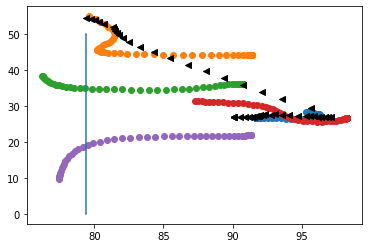

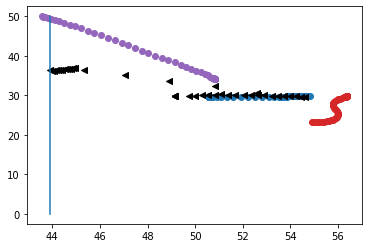

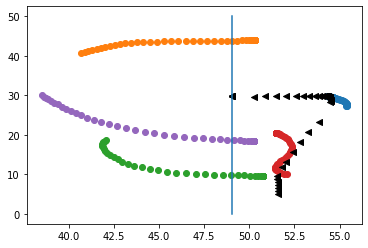

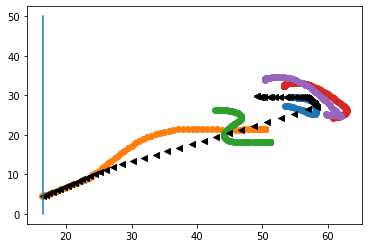

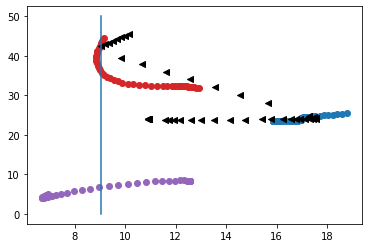

In [30]:
game_test = list(week1[week1.gameId == 2018090600].sort_values(by=['time'])['playId'].unique())
for j in game_test[:5]:
    catch = week1[(week1.playId == j) & (week1.gameId == 2018090600)]
    routes = catch[['x','y','displayName']]
    for i in names:
        if i=='Football':
            run = routes[routes.displayName == i]
            x = run.x
            y = run.y
            plt.scatter(list(x), list(y), c='black',marker='<')
            plt.plot([min(x), min(x)], [0, 50])

        elif i in list(checking.displayName):
            run = routes[routes.displayName == i]
            x = run.x
            y = run.y
            plt.scatter(list(x), list(y))


    plt.show()

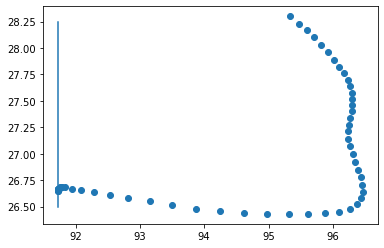

In [31]:
plt.scatter(list(mryan.x), list(mryan.y))
plt.plot([min(mx), min(mx)], [26.50, 28.25],)

In [32]:
testing.sort_values(by=['offensePlayResult'], ascending=False)

,gameId,playId,playDescription,passResult,playResult,offensePlayResult
12752,2018112509,2475,(10:47) B.Roethlisberger pass deep middle to J...,C,97,97
12011,2018112201,2897,(2:27) (Shotgun) D.Prescott pass deep middle t...,C,90,90
17665,2018123004,2619,(8:51) (Shotgun) P.Mahomes pass deep middle to...,C,89,89
14848,2018120910,1384,(10:00) (Shotgun) N.Mullens pass short right t...,C,85,85
16497,2018122310,3026,(2:32) (Shotgun) N.Foles pass deep middle to N...,C,83,83
...,...,...,...,...,...,...
13473,2018120202,3751,(8:26) M.Stafford sacked at DET 29 for -13 yar...,S,-18,-18
5599,2018100710,3875,(4:41) (Shotgun) C.Beathard sacked at SF 33 fo...,S,-41,-18
15621,2018121603,4458,(:24) (Shotgun) A.Rodgers sacked at CHI 27 for...,S,-18,-18
3026,2018092307,2712,(6:26) J.Allen sacked at BUF 42 for -13 yards ...,S,-19,-19
